# M5 Project

In this project you will solve a robot localization problem using the particle filtering technique. The problem is illustrated in the figures below. You will have two types of robots: the pacman (triangle) and the ghost (pentagon). The pacman can measure its distance to the landmarks (blue circles), but the ghost can only measure its distance to the pacman. The environment is cyclic, so when the pacman or the ghost cross one of the sides, it appears in the opposite side. You will have to code the downweigh and resample steps of the particle filtering code provided as starting point.

<img src="m5project1.png" width="400"/><img src="m5project2.png" width="400"/><img src="m5project3.png" width="400"/>

An initial version of the code with the problem specification (below) and a report template (at the bottom) are available in this notebook. Deliverables are the final code (non-functioning code is worth 0 points) and the report.

You must implement:
- downweigh and resample steps for the pacman (20pts)
- downweigh and resample steps for the ghost (20pts)

For your solution, describe the:
- how you updated the ghost particles without having the real location of the pacman (20pts)
- which other alternatives have you considered, and why you decided not to use them (10pts)

Run your code at least 10 times and:
- compare the uncertainty in the location of the pacman and the ghost over time (15pts)
- explain what causes the ghost particles to concentrate in a well-defined cluster (15pts) - see the rightmost picture above

# Implementation

In this project, you can only modify the last cell of code. The area that can be modified is marked between the comments "YOUR CODE STARTS HERE" and "YOUR CODE ENDS HERE".

In [4]:

import math
import random
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'numpy'

In [2]:
# world configuration
landmarks  = [[20.0, 20.0], [80.0, 80.0], [20.0, 80.0], [80.0, 20.0]]
world_size = 100.0

# generic robot implementation
class robot:
    def __init__(self):
        # initialise robot with random location and orientation
        self.x = random.random() * world_size
        self.y = random.random() * world_size
        self.orientation = random.random() * 2.0 * math.pi
        
        self.forward_noise = 0.0
        self.turn_noise    = 0.0
        self.sense_noise   = 0.0
    
    def set(self, new_x, new_y, new_orientation):
        if new_x < 0 or new_x >= world_size:
            raise ValueError('X coordinate out of bound')
        if new_y < 0 or new_y >= world_size:
            raise ValueError('Y coordinate out of bound')
        if new_orientation < 0 or new_orientation >= 2 * math.pi:
            raise ValueError('Orientation must be in [0..2pi]')
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)

    def set_noise(self, new_f_noise, new_t_noise, new_s_noise):
        self.forward_noise = float(new_f_noise);
        self.turn_noise    = float(new_t_noise);
        self.sense_noise   = float(new_s_noise);
    
    # apply noisy movement to robot
    def new_position(self, turn, forward):
        if forward < 0:
            raise ValueError('Robot cant move backwards')
        
        # turn, and add randomness to the turning command
        orientation = self.orientation + float(turn) + random.gauss(0.0, self.turn_noise)
        orientation %= 2 * math.pi
        
        # move, and add randomness to the motion command
        dist = float(forward) + random.gauss(0.0, self.forward_noise)
        x = self.x + (math.cos(orientation) * dist)
        y = self.y + (math.sin(orientation) * dist)
        x %= world_size    # cyclic truncate
        y %= world_size

        return x, y, orientation
    
    # model noise using Gaussians
    def Gaussian(self, mu, sigma, x):
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
        return math.exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / math.sqrt(2.0 * math.pi * (sigma ** 2))
    
# PacMan class
class pacman(robot):
    # the PacMan can sense its location using the landmarks
    def sense(self):
        Z = []
        for i in range(len(landmarks)):
            dist = math.sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            dist += random.gauss(0.0, self.sense_noise)
            Z.append(dist)
        return Z

    # calculates how likely a measurement should be
    def measurement_prob(self, measurement):
        prob = 1.0
        for i in range(len(landmarks)):
            dist = math.sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            prob *= self.Gaussian(dist, self.sense_noise, measurement[i])
        return prob

    def move(self, turn, forward):
        x, y, orientation = self.new_position(turn, forward)
        res = pacman()
        res.set(x, y, orientation)
        res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
        return res

# Ghost class
class ghost(robot):
    # the PacMan ("mypacman") can sense its distance to the ghost
    def sense(self, mypacman):
        Z = math.sqrt((self.x - mypacman.x) ** 2 + (self.y - mypacman.y) ** 2) + random.gauss(0.0, self.sense_noise)
        return Z

    # calculates how likely a measurement should be
    def measurement_prob(self, measurement, mypacman):
        dist = math.sqrt((self.x - mypacman.x) ** 2 + (self.y - mypacman.y) ** 2)
        prob = self.Gaussian(dist, self.sense_noise, measurement)
        return prob

    def move(self, turn, forward):
        x, y, orientation = self.new_position(turn, forward)
        res = ghost()
        res.set(x, y, orientation)
        res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
        return res

In [3]:
# world visualization with the distribution of particles
def show_belief(mypacman, pacman_particles, myghost, ghost_particles):
    plt.rcParams["figure.figsize"] = (5,5)

    for p in pacman_particles:
        plt.plot(p.x, p.y, marker=(3, 0, 180.0*p.orientation/math.pi), markerfacecolor='red', markersize=10, markeredgewidth=0.0, alpha=.3, linestyle='None')

    plt.plot(mypacman.x, mypacman.y, marker=(3, 0, 180.0*mypacman.orientation/math.pi), markerfacecolor='black', markersize=20, markeredgewidth=0.0, linestyle='None')

    for p in ghost_particles:
        plt.plot(p.x, p.y, marker=(5, 0, 180.0*p.orientation/math.pi), markerfacecolor='green', markersize=10, markeredgewidth=0.0, alpha=.3, linestyle='None')

    plt.plot(myghost.x, myghost.y, marker=(5, 0, 180.0*myghost.orientation/math.pi), markerfacecolor='black', markersize=20, markeredgewidth=0.0, linestyle='None')

    for x, y in landmarks:
          plt.plot(x, y, marker='o', markersize=20, markeredgewidth=2.0, markerfacecolor='None', markeredgecolor='blue')

    plt.xlim([0,100])
    plt.ylim([0,100])

    plt.show()

# measure the proximity between the real location and the distribution of particles
def eval(r, p):
    s = 0.0;
    for i in range(len(p)):
        dx = (p[i].x - r.x + (world_size/2.0)) % world_size - (world_size/2.0)
        dy = (p[i].y - r.y + (world_size/2.0)) % world_size - (world_size/2.0)
        err = math.sqrt(dx * dx + dy * dy)
        s += err
    return s / float(len(p))

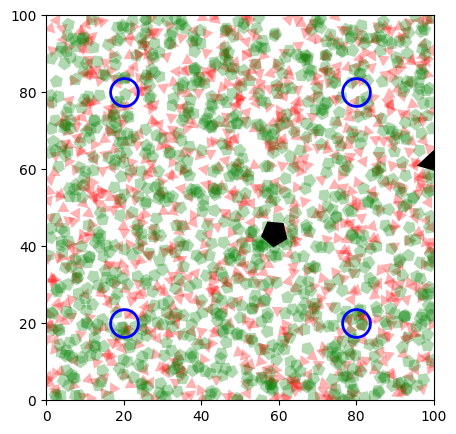

Average pacman distance: 37.75937885031202
Average ghost distance: 38.54235675234121


In [4]:
# pacman/ghost initialization
forward_noise = 3.0 
turn_noise = 0.05
sense_noise = 3.0

mypacman = pacman()
mypacman.set_noise(forward_noise, turn_noise, sense_noise)

myghost = ghost()
myghost.set_noise(forward_noise, turn_noise, sense_noise)

# particle distribution
N = 1000 # number of particles
T = 10   # number of moves

# initialise randomly guessed particles for pacman and ghost
p = []
g = []
for i in range(N):
    x = pacman()
    x.set_noise(forward_noise, turn_noise, sense_noise)
    p.append(x)
    x = ghost()
    x.set_noise(forward_noise, turn_noise, sense_noise)
    g.append(x)

show_belief(mypacman, p, myghost, g)

print("Average pacman distance:", eval(mypacman, p))
print("Average ghost distance:", eval(myghost, g))


Turn #1


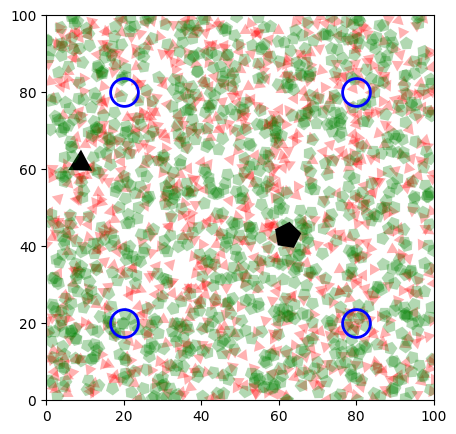

Average pacman distance before resample: 38.054358590884696
Average ghost distance before resample: 38.41538715893655


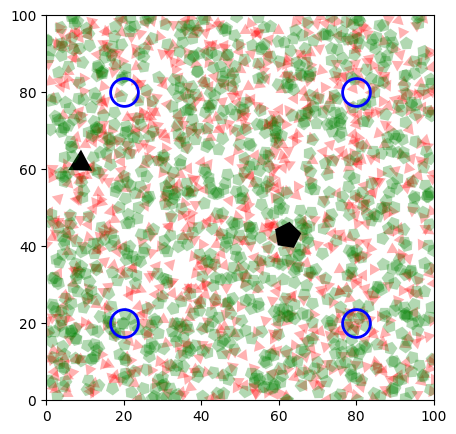

Average pacman distance after resample: 38.054358590884696
Average ghost distance after resample: 38.41538715893655

Turn #2


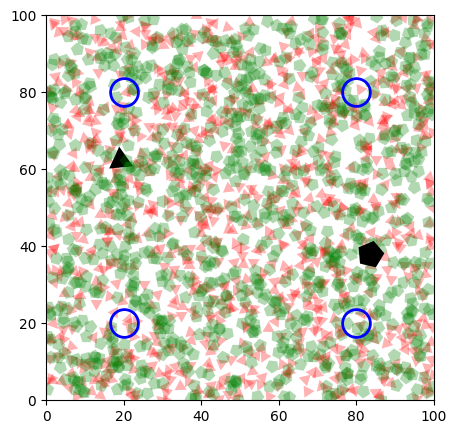

Average pacman distance before resample: 38.270996051496894
Average ghost distance before resample: 38.213592740616946


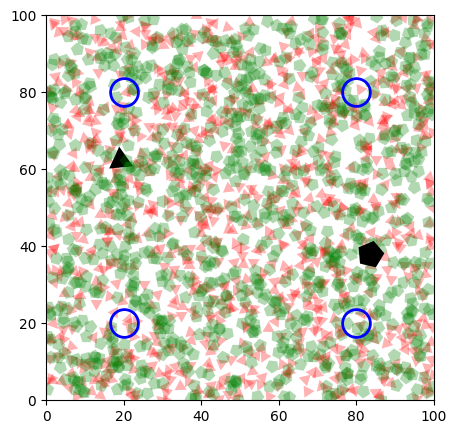

Average pacman distance after resample: 38.270996051496894
Average ghost distance after resample: 38.213592740616946

Turn #3


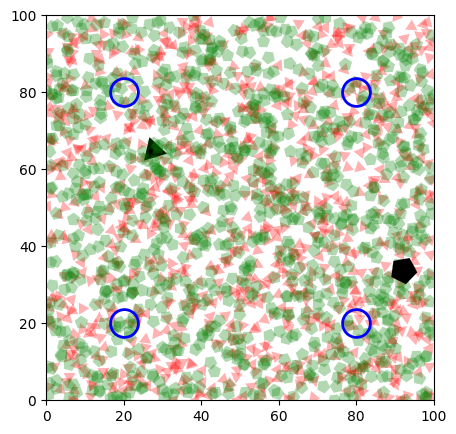

Average pacman distance before resample: 38.12522262534628
Average ghost distance before resample: 38.16501388256724


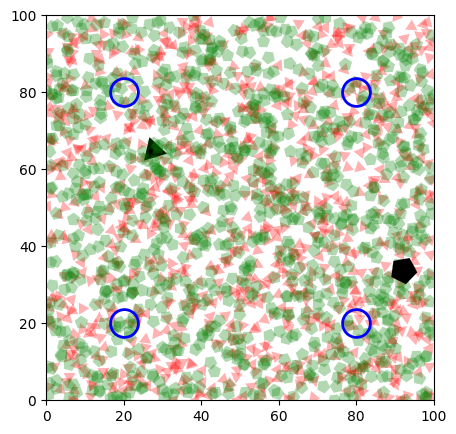

Average pacman distance after resample: 38.12522262534628
Average ghost distance after resample: 38.16501388256724

Turn #4


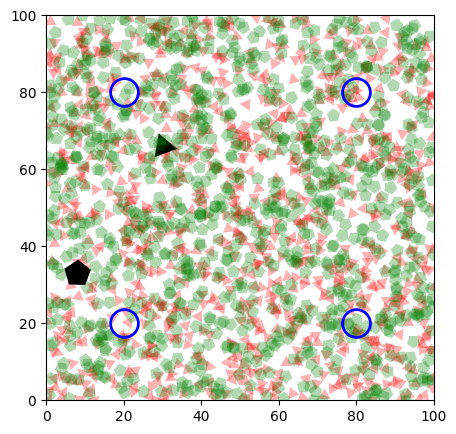

Average pacman distance before resample: 38.4232762000997
Average ghost distance before resample: 38.15147329553958


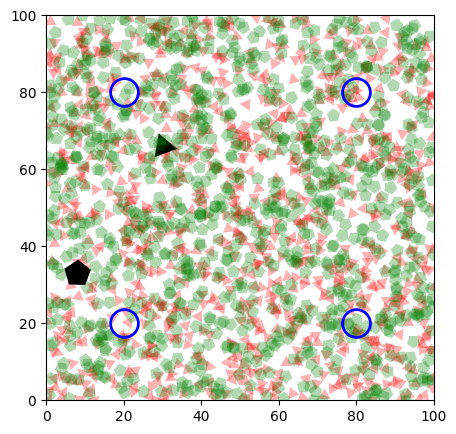

Average pacman distance after resample: 38.4232762000997
Average ghost distance after resample: 38.15147329553958

Turn #5


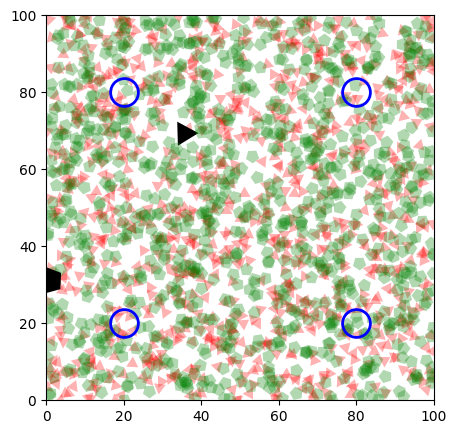

Average pacman distance before resample: 38.585962498423875
Average ghost distance before resample: 38.16009382602831


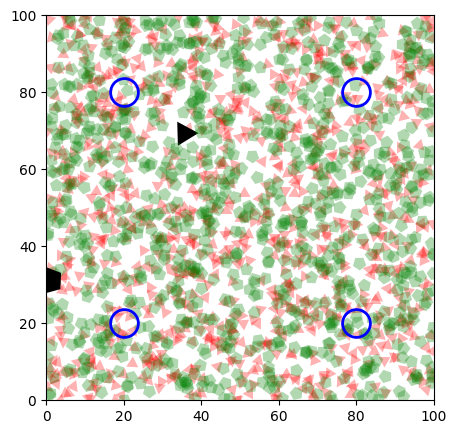

Average pacman distance after resample: 38.585962498423875
Average ghost distance after resample: 38.16009382602831

Turn #6


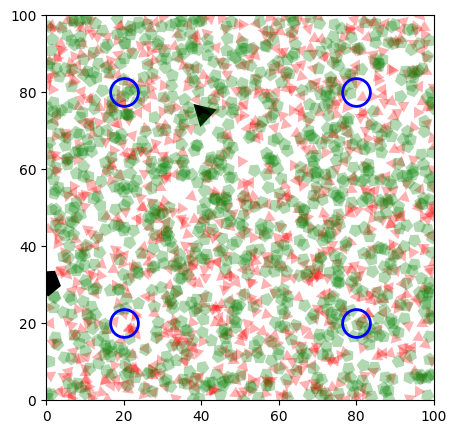

Average pacman distance before resample: 38.55005663219689
Average ghost distance before resample: 38.278914999118136


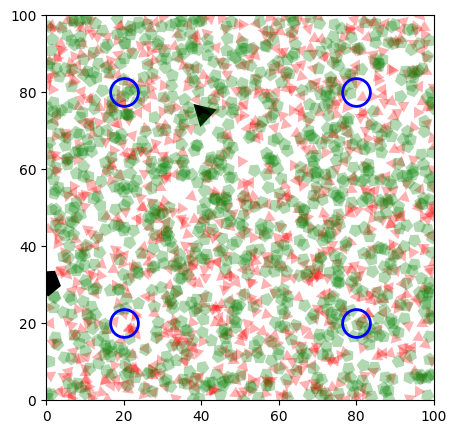

Average pacman distance after resample: 38.55005663219689
Average ghost distance after resample: 38.278914999118136

Turn #7


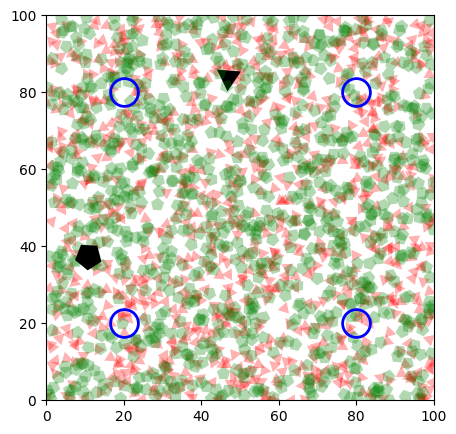

Average pacman distance before resample: 38.049084678996685
Average ghost distance before resample: 37.94310726115503


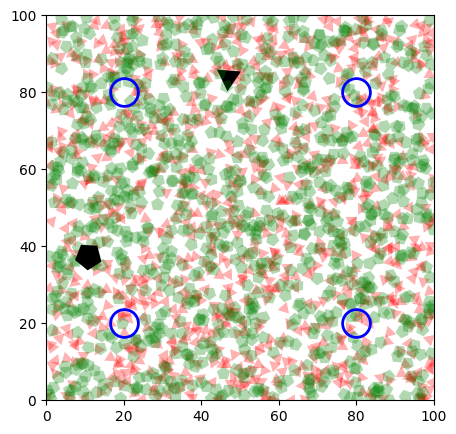

Average pacman distance after resample: 38.049084678996685
Average ghost distance after resample: 37.94310726115503

Turn #8


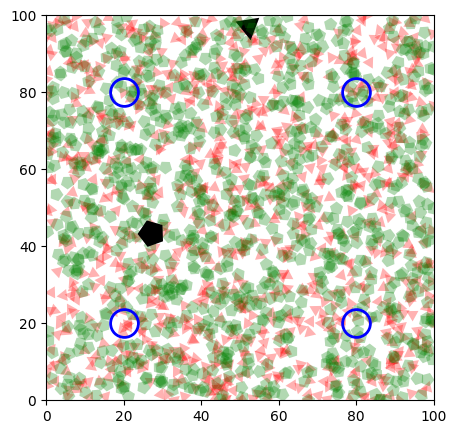

Average pacman distance before resample: 37.097093794541664
Average ghost distance before resample: 37.727173392240985


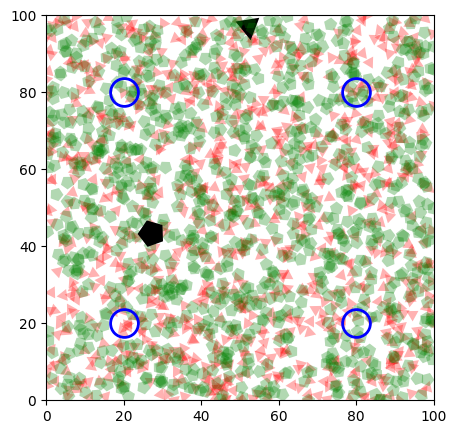

Average pacman distance after resample: 37.097093794541664
Average ghost distance after resample: 37.727173392240985

Turn #9


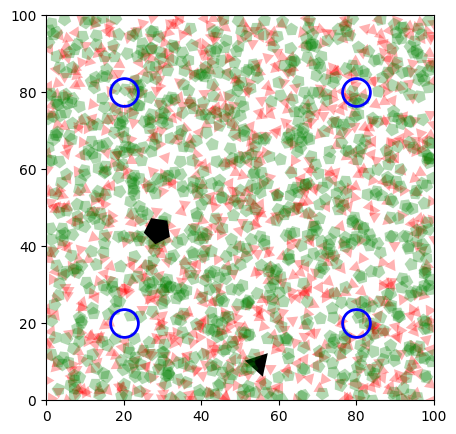

Average pacman distance before resample: 37.39875760044695
Average ghost distance before resample: 37.58876627052244


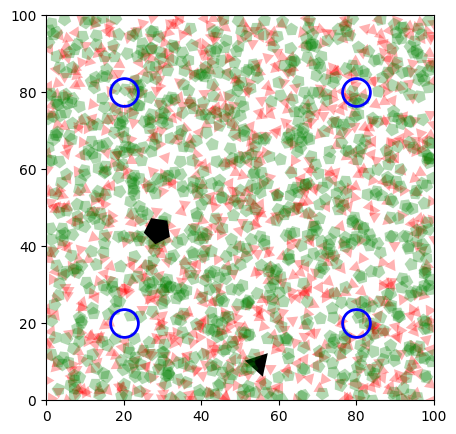

Average pacman distance after resample: 37.39875760044695
Average ghost distance after resample: 37.58876627052244

Turn #10


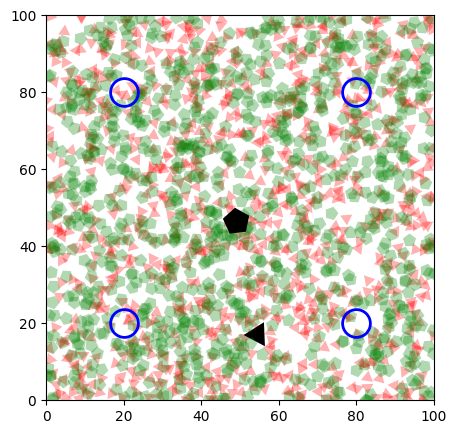

Average pacman distance before resample: 37.58780180724878
Average ghost distance before resample: 37.81999681523318


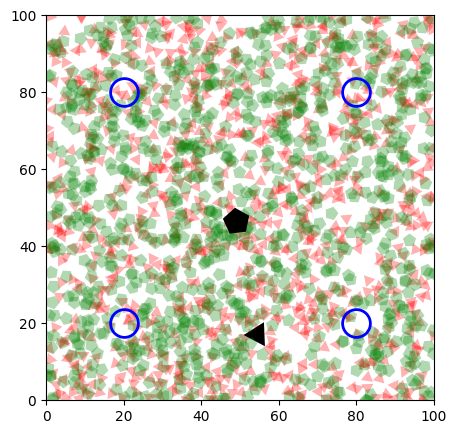

Average pacman distance after resample: 37.58780180724878
Average ghost distance after resample: 37.81999681523318


In [ ]:
for turn in range(T):
    print('\nTurn #{}'.format(turn+1))

    # real pacman movement
    # turn 0.1 and move 10 meters
    mypacman = mypacman.move(0.2, 10.0)

    # real move for ghost (random)
    gturn = (random.random()-0.5)*(math.pi/2.0) # random angle in [-45,45]
    gdist = random.random()*20.0           # random distance in [0,20]
    myghost = myghost.move(gturn, gdist)

    # elapse time
    # move particles using the same movement made by robot
    p2 = []
    g2 = []
    for i in range(N):
        p2.append(p[i].move(0.2, 10.0))
        g2.append(g[i].move(gturn, gdist))
    p = p2
    g = g2

    show_belief(mypacman, p, myghost, g)
    print("Average pacman distance before resample:", eval(mypacman, p))
    print("Average ghost distance before resample:", eval(myghost, g))

    # observe
    ZP = mypacman.sense()        # noisy measurement of the distance between the pacman and the landmarks
    ZG = myghost.sense(mypacman) # noisy measurement of the distance between the pacman and the ghost

 # Calculate weights for PacMan particles
    pacman_weights = [particle.measurement_prob(ZP) for particle in p]

    # Calculate weights for Ghost particles based on distances to PacMan particles
    ghost_weights = [
        sum([ghost_particle.measurement_prob(pacman_particle.sense(), pacman_particle)
             for pacman_particle in p]) / len(p)
        for ghost_particle in g
    ]

    # Normalize weights
    pacman_weights_sum = sum(pacman_weights)
    ghost_weights_sum = sum(ghost_weights)
    
    if pacman_weights_sum > 0:
        pacman_weights = [w / pacman_weights_sum for w in pacman_weights]
    if ghost_weights_sum > 0:
        ghost_weights = [w / ghost_weights_sum for w in ghost_weights]

    # Resample particles based on weights
    p = resample_particles(p, pacman_weights)
    g = resample_particles(g, ghost_weights)

    show_belief(mypacman, p, myghost, g)
    print("Average pacman distance after resample:", eval(mypacman, p))
    print("Average ghost distance after resample:", eval(myghost, g))

# Report template

## Solution description

How you updated the ghost particles without having the real location of the pacman?

The ghost particles are updated based on the noise that the "real" PacMan produces. The measurement ZG simulates what is preceived to be about where Pacman would be at. The weight caluclation uses the measurement probability and the liklihood of how close the distance to Pacman would be. After calculating the weights I resampled the particles to focus on aligning with the noisy observations. 

Which other alternatives have you considered, and why you decided not to use them?
Direct knowledge of Pacman's location could be used but it goes against the idea of particle filtering. It would make the simulation unrealistic.

## Experimental results

Here I compare the uncertainty in the location of the pacman and the ghost over time... Over time there would be sufficient observations. As time goes on the ghost collects successive noisy movements and measures them out. This allows for the particle filter to hone in on a specific region. This reduces uncertainty and helps the particles to cluster. Pacman's particles could show a different behavior with a higher uncertainty with land-mark based sensing and a wider spread in uncertain envirnoments.

The ghost particles tend to concentrate in a well-defined cluster when the ghost's movements and observations provide reliable and consistent information. The clustering is indicative of a reduction in uncertainty over time
